# Movie recommendation System

In this implementation, when the user searches for a movie we will recommend the top 10 similar movies using our movie recommendation system. We will be using an item-based collaborative filtering algorithm for our purpose. 

In [1]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
from sklearn import model_selection
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances
movies = pd.read_csv("/Users/sridhar/Downloads/ml-latest-small/movies.csv")
ratings = pd.read_csv("/Users/sridhar/Downloads/ml-latest-small/ratings.csv")

In [2]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [3]:
movies.shape

(9742, 3)

Movie dataset has

movieId – once the recommendation is done, we get a list of all similar movieId and get the title for each movie from this dataset.
genres – which is not required for this filtering approach.

In [4]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [5]:
ratings.shape

(100836, 4)

Ratings dataset has-

userId – unique for each user. 
movieId – using this feature, we take the title of the movie from the movies dataset.
rating – Ratings given by each user to all the movies using this we are going to predict the top 10 similar movies.

Here, we can see that userId 1 has watched movieId 1 & 3 and rated both of them 4.0 but has not rated movieId 2 at all. This interpretation is harder to extract from this dataframe. Therefore, to make things easier to understand and work with, we are going to make a new dataframe where each column would represent each unique userId and each row represents each unique movieId.

In [6]:
final_dataset = ratings.pivot(index='movieId',columns='userId',values='rating')
final_dataset.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,NaN,NaN,4.0,NaN,4.5,NaN,NaN,NaN,...,4.0,NaN,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,NaN,NaN,NaN,NaN,NaN,4.0,NaN,4.0,NaN,NaN,...,NaN,4.0,NaN,5.0,3.5,NaN,NaN,2.0,NaN,NaN
3,4.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN


# Data Cleaning

Now, it’s much easier to interpret that userId 1 has rated movieId 1& 3 4.0 but has not rated movieId 3,4,5 at all (therefore they are represented as NaN ) and therefore their rating data is missing.

Let’s fix this and impute NaN with 0 to make things understandable for the algorithm and also making the data more eye-soothing.

In [7]:
final_dataset.fillna(0,inplace=True)
final_dataset.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,...,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,...,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0



# Removing Noise from the data

In the real-world, ratings are very sparse and data points are mostly collected from very popular movies and highly engaged users. We wouldn’t want movies that were rated by a small number of users because it’s not credible enough. Similarly, users who have rated only a handful of movies should also not be taken into account.

So with all that taken into account and some trial and error experimentations,  we will reduce the noise by adding some filters for the final dataset.

To qualify a movie, a minimum of 10 users should have voted a movie.
To qualify a user, a minimum of 50 movies should have voted by the user.

# Let’s visualize how these filters look like

Aggregating the number of users who voted and the number of movies that were voted.



In [8]:
no_user_voted = ratings.groupby('movieId')['rating'].agg('count')
no_movies_voted = ratings.groupby('userId')['rating'].agg('count')
print(no_user_voted)
print(no_movies_voted)

movieId
1         215
2         110
3          52
4           7
5          49
         ... 
193581      1
193583      1
193585      1
193587      1
193609      1
Name: rating, Length: 9724, dtype: int64
userId
1       232
2        29
3        39
4       216
5        44
       ... 
606    1115
607     187
608     831
609      37
610    1302
Name: rating, Length: 610, dtype: int64


Let’s visualize the number of users who voted with our threshold of 10.

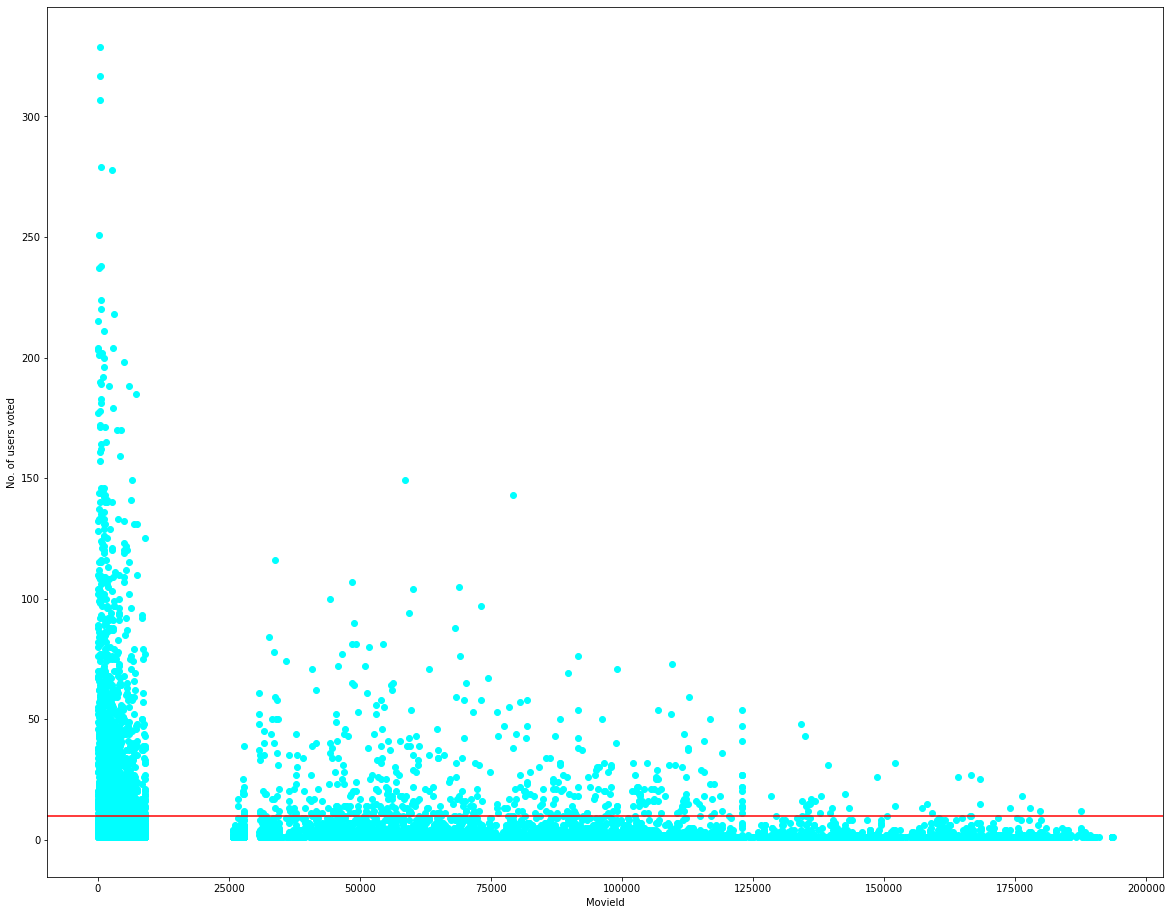

In [9]:
f,ax = plt.subplots(1,1,figsize=(20,16))
#ratings['rating'].plot(kind='hist')
plt.scatter(no_user_voted.index,no_user_voted,color='cyan')
plt.axhline(y=10,color='r')
plt.xlabel('MovieId')
plt.ylabel('No. of users voted')
plt.show()

Making the necessary modifications as per the threshold set.

In [10]:
final_dataset = final_dataset.loc[no_user_voted[no_user_voted > 10].index,:]

In [11]:
final_dataset.shape

(2121, 610)

Let’s visualize the number of votes by each user with our threshold of 50.

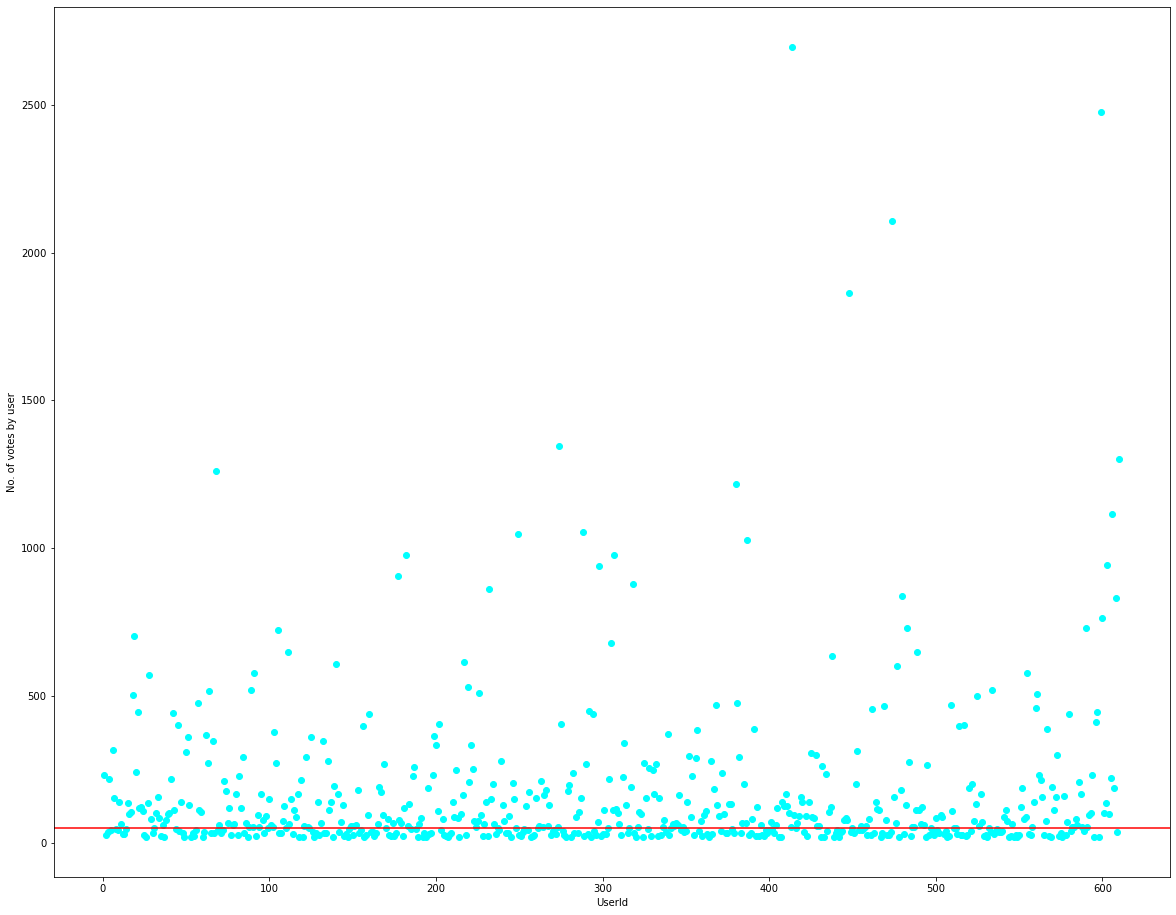

In [12]:
f,ax = plt.subplots(1,1,figsize=(20,16))
plt.scatter(no_movies_voted.index,no_movies_voted,color='cyan')
plt.axhline(y=50,color='r')
plt.xlabel('UserId')
plt.ylabel('No. of votes by user')
plt.show()

Making the necessary modifications as per the threshold set.

In [13]:
final_dataset=final_dataset.loc[:,no_movies_voted[no_movies_voted > 50].index]
final_dataset

userId,1,4,6,7,10,11,15,16,17,18,...,600,601,602,603,604,605,606,607,608,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,4.5,0.0,0.0,2.5,0.0,4.5,3.5,...,2.5,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,5.0
2,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,...,4.0,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0
3,4.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
5,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.5,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
6,4.0,0.0,4.0,0.0,0.0,5.0,0.0,0.0,0.0,4.0,...,0.0,0.0,3.0,4.0,3.0,0.0,0.0,0.0,0.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174055,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
176371,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
177765,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Removing sparsity

Our final_dataset has dimensions of 2121 * 378 where most of the values are sparse. We are using only a small dataset but for the original large dataset of movie lens which has more than 100000 features, our system may run out of computational resources when that is feed to the model. To reduce the sparsity we use the csr_matrix function from the scipy library.

In [14]:
sample = np.array([[0,0,3,0,0],[4,0,0,0,2],[0,0,0,0,1]])
sparsity = 1.0 - ( np.count_nonzero(sample) / float(sample.size) )
print(sparsity)

0.7333333333333334


In [15]:
csr_sample = csr_matrix(sample)
print(csr_sample)

  (0, 2)	3
  (1, 0)	4
  (1, 4)	2
  (2, 4)	1


As you can see there is no sparse value in the csr_sample and values are assigned as rows and column index. for the 0th row and 2nd column, the value is 3.

Applying the csr_matrix method to the dataset :

In [16]:
csr_data = csr_matrix(final_dataset.values)
final_dataset.reset_index(inplace=True)
final_dataset.head()

userId,movieId,1,4,6,7,10,11,15,16,17,...,600,601,602,603,604,605,606,607,608,610
0,1,4.0,0.0,0.0,4.5,0.0,0.0,2.5,0.0,4.5,...,2.5,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,5.0
1,2,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0
2,3,4.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
3,5,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.5,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
4,6,4.0,0.0,4.0,0.0,0.0,5.0,0.0,0.0,0.0,...,0.0,0.0,3.0,4.0,3.0,0.0,0.0,0.0,0.0,5.0


In [17]:
arr = csr_matrix(csr_data, dtype=np.int8).toarray()
print(arr)

[[4 0 0 ... 4 2 5]
 [0 0 4 ... 0 2 0]
 [4 0 5 ... 0 2 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [18]:
cos_sim_1_2 = cosine_similarity([arr[0, :], arr[5, :]])
print('Cosine Similarity is \n',cos_sim_1_2 )

Cosine Similarity is 
 [[1.         0.25784742]
 [0.25784742 1.        ]]


In [19]:
print('Cosine distance: ', cosine_distances([arr[0, :], arr[5, :]]))

Cosine distance:  [[0.         0.74215258]
 [0.74215258 0.        ]]


# Making the movie recommendation system model


We will be using the KNN algorithm to compute similarity with cosine distnce metric which is very fast and more preferable than pearson coefficient 



In [20]:
knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)
model = knn.fit(csr_data)

# Making the recommendation function


The working principle is very simple. We first check if the movie name input is in the database and if it is we use our recommendation system to find similar movies and sort them based on their similarity distance and output only the top 10 movies with their distances from the input movie.

In [21]:
def get_movie_recommendation(movie_name):
    n_movies_to_reccomend = 10
    movie_list = movies[movies['title'].str.contains(movie_name)]  
    if len(movie_list):        
        movie_idx= movie_list.iloc[0]['movieId']
        movie_idx = final_dataset[final_dataset['movieId'] == movie_idx].index[0]
        distances , indices = knn.kneighbors(csr_data[movie_idx],n_neighbors=n_movies_to_reccomend+1)    
        rec_movie_indices = sorted(list(zip(indices.squeeze().tolist(),distances.squeeze().tolist())),key=lambda x: x[1])[:0:-1]
        recommend_frame = []
        for val in rec_movie_indices:
            movie_idx = final_dataset.iloc[val[0]]['movieId']
            idx = movies[movies['movieId'] == movie_idx].index
            recommend_frame.append({'Title':movies.iloc[idx]['title'].values[0],'Distance':val[1]})
        df = pd.DataFrame(recommend_frame,index=range(1,n_movies_to_reccomend+1))
        return df
    else:
        return "No movies found. Please check your input"

# Finally, Let’s Recommend some movies!

In [22]:
get_movie_recommendation('Iron Man')


,Title,Distance
1,Up (2009),0.368857
2,Guardians of the Galaxy (2014),0.368758
3,Watchmen (2009),0.368558
4,Star Trek (2009),0.366029
5,Batman Begins (2005),0.362759
6,Avatar (2009),0.310893
7,Iron Man 2 (2010),0.307492
8,WALL·E (2008),0.298138
9,"Dark Knight, The (2008)",0.285835
10,"Avengers, The (2012)",0.285319


In [23]:
get_movie_recommendation('Memento')


,Title,Distance
1,American Beauty (1999),0.389346
2,American History X (1998),0.388615
3,Pulp Fiction (1994),0.386235
4,"Lord of the Rings: The Return of the King, The...",0.371622
5,Kill Bill: Vol. 1 (2003),0.350167
6,"Lord of the Rings: The Two Towers, The (2002)",0.348358
7,Eternal Sunshine of the Spotless Mind (2004),0.346196
8,"Matrix, The (1999)",0.326215
9,"Lord of the Rings: The Fellowship of the Ring,...",0.316777
10,Fight Club (1999),0.272380


In [24]:
get_movie_recommendation('Fight Club')


,Title,Distance
1,Kill Bill: Vol. 2 (2004),0.336416
2,"Lord of the Rings: The Return of the King, The...",0.325792
3,Eternal Sunshine of the Spotless Mind (2004),0.324751
4,American Beauty (1999),0.311649
5,"Lord of the Rings: The Fellowship of the Ring,...",0.310610
6,Kill Bill: Vol. 1 (2003),0.302076
7,Pulp Fiction (1994),0.295286
8,American History X (1998),0.293905
9,Memento (2000),0.272380
10,"Matrix, The (1999)",0.229824


In [25]:
get_movie_recommendation('jsnckjsdcsc')

'No movies found. Please check your input'

In [26]:
get_movie_recommendation('Dark Knight')

,Title,Distance
1,Inglourious Basterds (2009),0.374613
2,Kill Bill: Vol. 1 (2003),0.364388
3,WALL·E (2008),0.364129
4,Avatar (2009),0.358937
5,"Hangover, The (2009)",0.348019
6,"Lord of the Rings: The Return of the King, The...",0.347528
7,"Dark Knight Rises, The (2012)",0.308688
8,Batman Begins (2005),0.306755
9,Iron Man (2008),0.285835
10,Inception (2010),0.213876


In [27]:
get_movie_recommendation('Dunkirk')


,Title,Distance
1,"Wolf of Wall Street, The (2013)",0.579830
2,The Hateful Eight (2015),0.563029
3,Paths of Glory (1957),0.556317
4,Guardians of the Galaxy 2 (2017),0.554890
5,Thor: Ragnarok (2017),0.554185
6,Sicario (2015),0.534809
7,The Artist (2011),0.519898
8,"Big Short, The (2015)",0.512684
9,Arrival (2016),0.509473
10,Blade Runner 2049 (2017),0.305579


In [28]:
get_movie_recommendation('Wolf of Wall Street')

,Title,Distance
1,Gone Girl (2014),0.460765
2,Whiplash (2014),0.454201
3,The Revenant (2015),0.447583
4,"Big Short, The (2015)",0.446903
5,Django Unchained (2012),0.430367
6,Shutter Island (2010),0.428555
7,The Martian (2015),0.425035
8,"Dark Knight Rises, The (2012)",0.412159
9,Her (2013),0.411062
10,Deadpool (2016),0.408168


In [29]:
get_movie_recommendation('Scarface')

,Title,Distance
1,American Psycho (2000),0.471233
2,Donnie Darko (2001),0.467661
3,"Godfather, The (1972)",0.466888
4,"Big Lebowski, The (1998)",0.466746
5,Fight Club (1999),0.464654
6,Kill Bill: Vol. 1 (2003),0.449598
7,"Departed, The (2006)",0.444265
8,Gangs of New York (2002),0.434544
9,Reservoir Dogs (1992),0.431892
10,Kill Bill: Vol. 2 (2004),0.416276


In [30]:
get_movie_recommendation('Godfather')

,Title,Distance
1,Fargo (1996),0.362356
2,"Silence of the Lambs, The (1991)",0.361809
3,American Beauty (1999),0.360804
4,Reservoir Dogs (1992),0.360162
5,Fight Club (1999),0.358305
6,One Flew Over the Cuckoo's Nest (1975),0.357212
7,Pulp Fiction (1994),0.352409
8,Star Wars: Episode IV - A New Hope (1977),0.349061
9,Goodfellas (1990),0.295961
10,"Godfather: Part II, The (1974)",0.154159


In [31]:
get_movie_recommendation('Pulp Fiction')

,Title,Distance
1,Goodfellas (1990),0.329255
2,American Beauty (1999),0.328066
3,"Matrix, The (1999)",0.319978
4,Fargo (1996),0.310647
5,Fight Club (1999),0.295286
6,"Usual Suspects, The (1995)",0.278261
7,Forrest Gump (1994),0.275716
8,Seven (a.k.a. Se7en) (1995),0.273683
9,"Shawshank Redemption, The (1994)",0.249804
10,"Silence of the Lambs, The (1991)",0.249232


In [32]:
get_movie_recommendation('Rosemary\'s Baby')

,Title,Distance
1,Chinatown (1974),0.575258
2,"Third Man, The (1949)",0.574224
3,Rebecca (1940),0.555199
4,Misery (1990),0.550489
5,"Shining, The (1980)",0.549078
6,Carrie (1976),0.549062
7,"Omen, The (1976)",0.520273
8,"Exorcist, The (1973)",0.499612
9,"Birds, The (1963)",0.482869
10,Psycho (1960),0.458052


In [33]:
get_movie_recommendation('Avengers: Infinity War')

,Title,Distance
1,Blade Runner 2049 (2017),0.467723
2,Black Panther (2017),0.420381
3,Arrival (2016),0.414004
4,Star Wars: The Last Jedi (2017),0.405511
5,Doctor Strange (2016),0.367247
6,Captain America: Civil War (2016),0.355038
7,Guardians of the Galaxy 2 (2017),0.318713
8,Untitled Spider-Man Reboot (2017),0.257129
9,Deadpool 2 (2018),0.225270
10,Thor: Ragnarok (2017),0.190964


In [35]:
print('Root Mean Squared Error: ')
RMSE = np.sqrt(np.mean(arr**2))
RMSE

Root Mean Squared Error: 


1.0774792624494953

In [41]:
 norm=np.amax(arr)-np.amin(arr)

In [42]:
Nomalized_RMSE = RMSE/norm
print('Normalised Root Mean Squared Error: ')
Nomalized_RMSE

Normalised Root Mean Squared Error: 


0.21549585248989905